In [2]:
#Introduction
#Given a task to develop a model to forecast South Korea's monthly Total Exports, I decided to use Python and to focus on simplicity for the model. 
#My data is taken from [ref4] which is a seasonally adjusted dataset for "Trade in goods: all countries", with a time period of ~10 years and monthly 
#datapoints starting from 2014 August and ending on 2024 June, as I wanted at least 100 datapoints when working with a autoregression (AR) model [ref3].
#After browsing a few sources on modelling this sort of data, I decided on ARIMA as my model. (“AutoRegressive Integrated Moving Average.”)

#Why model exports? Forecasting exports helps in many areas such as Supply Chain management, International Trade, planning in general, etc.
#Having a more complete picture of whats to come is always a good thing for any firm or economic agent, and could help in reducing market inefficiencies. 

In [3]:
#Key Assumptions wrt ARIMA
#1. Stationarity 
#2. Seasonality is well accounted for by the UK Office for National Statistics in the dataset, no need to employ sARIMA

In [4]:
#Methodology Selection/Overview

#Given the assumptions above, I chose to proceed with building an ARIMA model as directed by [ref1].

#################################################################################################
#DISCLAIMER: My methodology is heavily (HEAVILY) influenced by a youtube video I watched [ref2].#
#################################################################################################

#The steps taken to create this model are roughly outlined below:
#1. Clean up and prepare the SK export data 
#2. Perform relevant statistical tests and determine parameters for manual ARIMA model (Optimization) 
#3. Create Autofit ARIMA model 
#4. Compare Manual and Autofit ARIMA model using test dataset
#5. Compare forecast plots visually and by calculating error.

In [5]:
#1. Clean SK export Data was performed off-screen (so to speak) and saved in one column of data as 'skexportdata.csv'
#I converted the months to numbers (1->2014 Aug, 119->2021 June) because I wanted to perform logarithmic transformation on the data in later steps. 

###Things to note about the data: all data is current prices, seasonally adjusted and in pounds million.###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   223     118 non-null    int64
dtypes: int64(1)
memory usage: 1.1 KB


<Axes: >

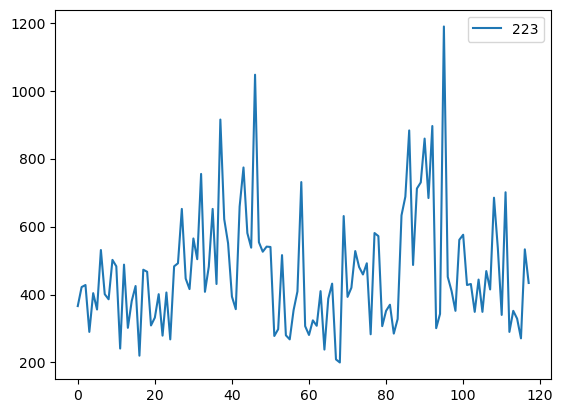

In [6]:
#I plotted the dataset to look to deal with inconsistent variance
import pandas as pd 
df = pd.read_csv('skexportdata.csv')
df.info()
df.plot()
#(y=export value in pounds million, x=number of months, with 2014 Aug being Month 0)
#Seems to fluctuate around a gradually increasing average over 10y. However, the variance seems to increase in the region around x=40 and x=100.
#I decided to transform the data with log seeing this inconsistent variance to see if any improvement could be made

<Axes: >

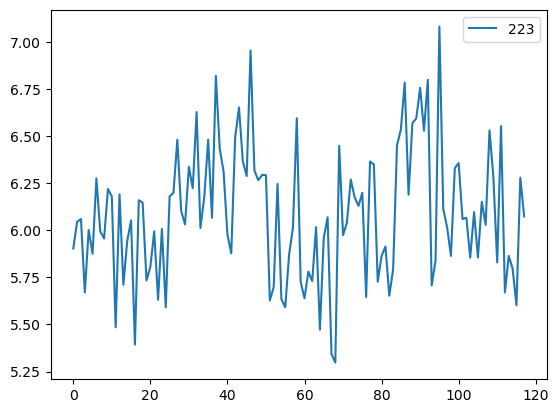

In [7]:
import numpy as np 
df = np.log(df)
df.plot()
#variance barely changed after doing this honestly so in the interest of saving brain i will convert df back to
#the original data values, it is also super likely that ARIMA parameters i use will be (p, 0, q).

<Axes: >

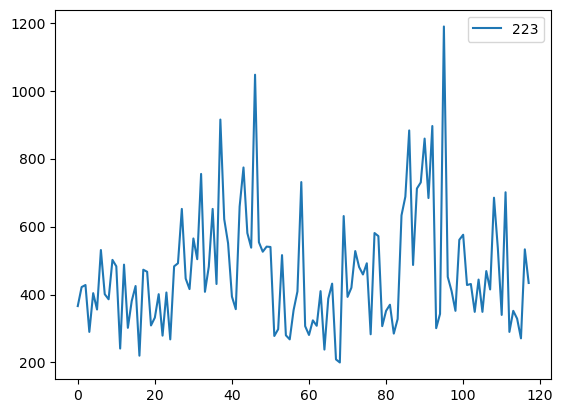

In [8]:
df=np.exp(df) #log is base e 
df.plot()

In [9]:
#setting up Test and Training dataset
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

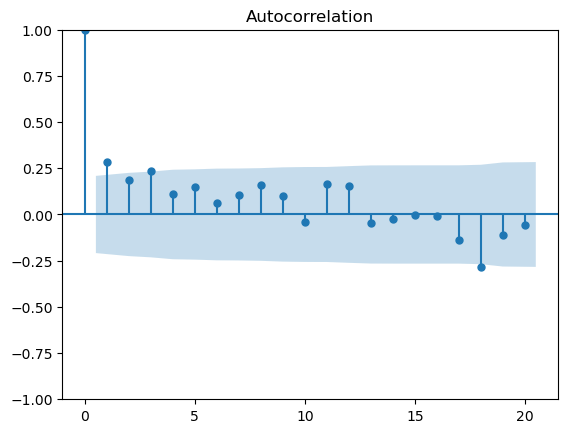

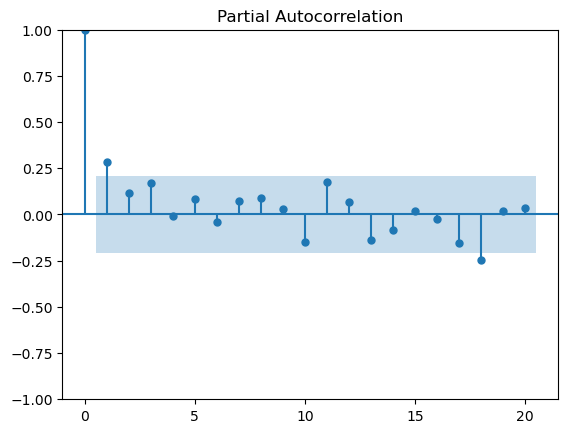

In [10]:
#Checking for stationarity of Time Series:

#Visually, the plot above looks stationary, without a general trend in either direction and mostly consistent variance.
#In the interest of confirming this, I will use two other methods to evaluate the dataset.  

#Method 1: ACF plot and PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)
#As we can see from the ACF and PACF plots below, there are no significant repeating timelags, so my assumptions that seasonality within a period of 
#10 years has been accounted for is likely to be correct. 

#taking reference from [ref5,ref6], the ACF and PACF plots did not show me the typical features of an AR or MA process, seemingly an indication a mixed ARMA 
#model being needed instead. 

#ACF plot: Its a bit of a stretch of imagination, but I took the two points lag order = 0,1 as above the blue area. The presence of 2 significant lags 
#at 0,1 before dropping below the blue area suggests to me that this ACF plot should inform the parameter for the MA process, with q=2.

#PACF plot: Again, might be stretch, but I observe significant lags at lag order = 0,1 only. This is indicative, to me, of an AR process. Thus, I chose
#to use p=2 for the AR process. 

#(p,q)=(2,3)




######DISCLAIMER: At this step, I could also just not proceed with this dataset or even try to forecast SK exports, as the ACF and PACF plots are 
#practically those of white noise. I acknowledge I am applying interpretation of ACF and PACF plots a little loosely (and maybe wrongly) in this step. 

In [11]:
#Method 2: ADF (Augmented Dickey-Fuller) test 

#I will be using this test to help determine the I component parameter of the ARIMA model as well as to check the stationarity of the dataset.
#(Recall that visually, the time series looks stationary, so it is likely that I will end up using d=0 for the I component parameter. but we 
#will still proceed with ADF test for fun) 
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print({adf_test[1]})

#null-hypothesis: there is a unit root(non-stationary) 
#interpreting the p-value obtained from the ADF test p = ~1.4e-09: the p-value is much smaller than 0.05, so we successfully reject the null hypothesis 
#that the time series is non-stationary and thus conclude this at the 5% significance level. 

#No further ADF testing or transformation of the time series is required, and we set the d parameter to 0 for the I component of the ARIMA model. 

{1.406728247997145e-09}


In [12]:
#Manual ARIMA model fitting given (p,d,q)=(2,0,3)

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order = (2,0,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    223   No. Observations:                   88
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -562.884
Date:                Fri, 16 Aug 2024   AIC                           1139.769
Time:                        11:59:12   BIC                           1157.110
Sample:                             0   HQIC                          1146.755
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        453.2745     45.239     10.020      0.000     364.608     541.941
ar.L1          0.0146      0.200      0.073      0.942      -0.377       0.406
ar.L2          0.6581      0.246      2.672      0.0

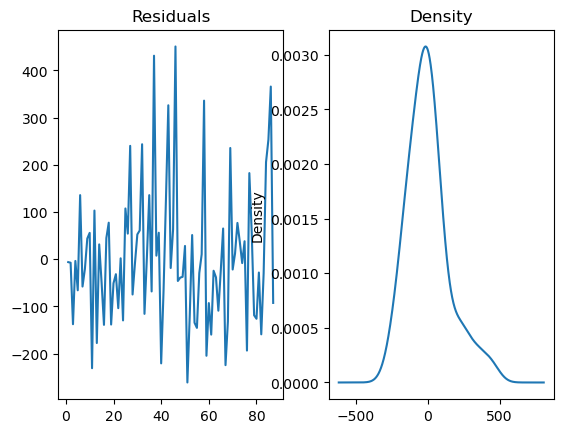

In [13]:
#Plotting residals to ensure adequate data has been captured for the model. 

import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

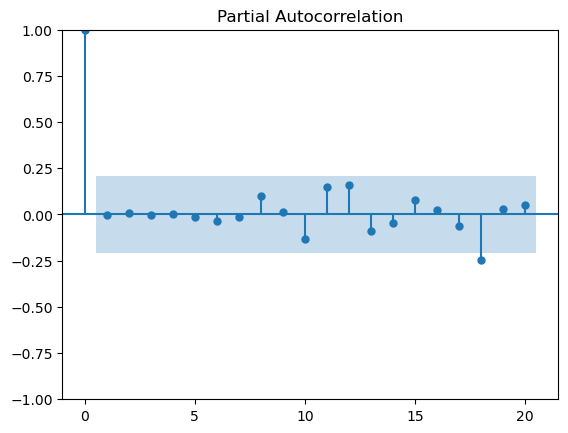

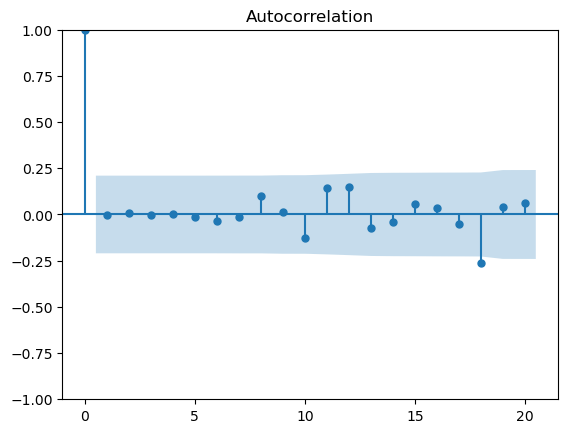

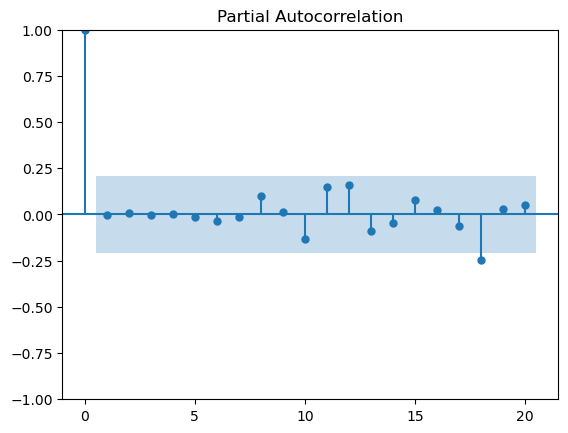

In [14]:
plot_acf(residuals)
plot_pacf(residuals)

In [15]:
#Interpreting Residuals plotted and ACF/PACF: 

#Residuals look random, and are roughly normally distributed with a mean of around 0. 
#ACF and PACF consistent with ACF and PACF for white noise. In conclusion, dataset is adequate for the model.

<Axes: >

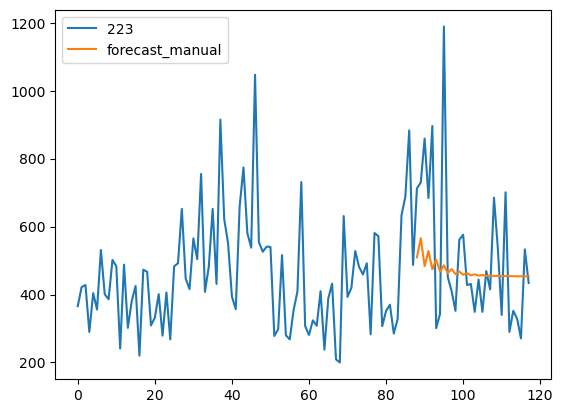

In [16]:
#Plotting the forecasted values with the manual ARIMA model

forecast_test = model_fit.forecast(len(df_test))
df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)
df.plot()

In [17]:
#Interpretation of plot: 

#No significant correlation with the training data in terms of predicting swings, predicts export value at the end of the timeframe to a fair degree of 
#accuracy. 

In [18]:
#Autofitting ARIMA

import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima
#we get an autofitted ARIMA model wth parameters (1,0,1)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [19]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   88
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -569.648
Date:                Fri, 16 Aug 2024   AIC                           1145.296
Time:                        11:59:20   BIC                           1152.728
Sample:                             0   HQIC                          1148.290
                                 - 88                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9973      0.008    129.612      0.000       0.982       1.012
ma.L1         -0.7714      0.079     -9.812      0.000      -0.925      -0.617
sigma2      2.368e+04   3540.053      6.689      0.000    1.67e+04    3.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 8.26
Prob(Q):                              0.80   Prob(JB):                         0.02
Heteroskedasticity (H):               2.22   Skew:                             0.72
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                               SARIMAX Results                                
Dep. Variable:                    223   No. Observations:                   88
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -565.810
Date:                Fri, 16 Aug 2024   AIC                           1139.619
Time:                        11:59:21   BIC                           1149.529
Sample:                             0   HQIC                          1143.612
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        455.9017     45.068     10.116      0.000     367.569     544.234
ar.L1          0.8438      0.127      6.669      0.000       0.596       1.092
ma.L1         -0.6434      0.183     -3.523      0.0

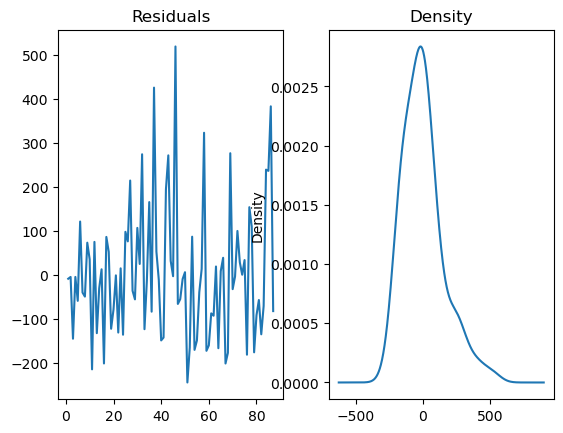

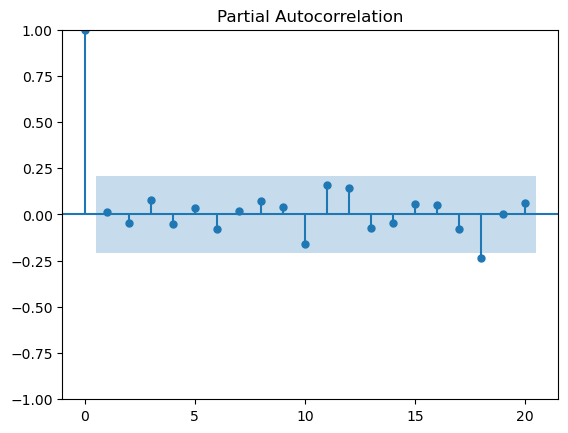

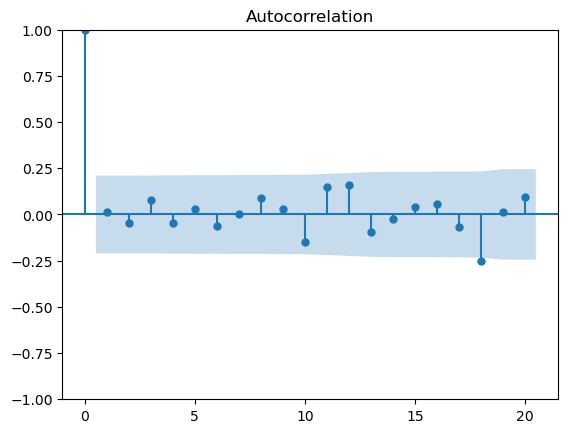

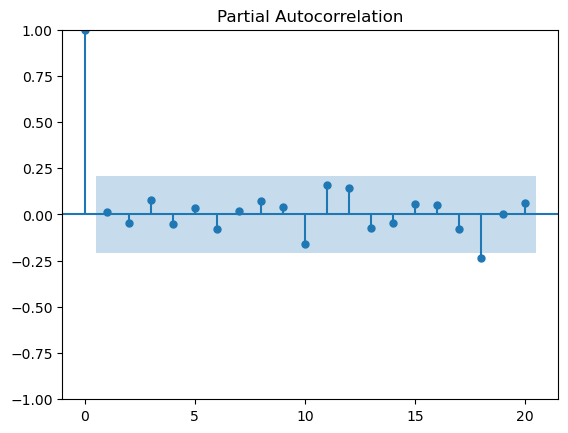

In [20]:
#Checking Residuals of Autofitted ARIMA 

modela = ARIMA(df_train, order = (1,0,1)) #modela - model AUTO
modela_fit = modela.fit()
print(modela_fit.summary())
import matplotlib.pyplot as plt
residualsa = modela_fit.resid[1:] #residualsa - residuals AUTO
fig, ax = plt.subplots(1,2)
residualsa.plot(title='Residuals', ax=ax[0])
residualsa.plot(title='Density', kind='kde', ax=ax[1])
plt.show()
plot_acf(residualsa)
plot_pacf(residualsa)

In [21]:
#Interpreting Residuals plotted and ACF/PACF: 

#Residuals look random, and are roughly normally distributed with a mean of around 0. 
#ACF and PACF consistent with ACF and PACF for white noise. In conclusion, dataset is adequate for the model.

<Axes: >

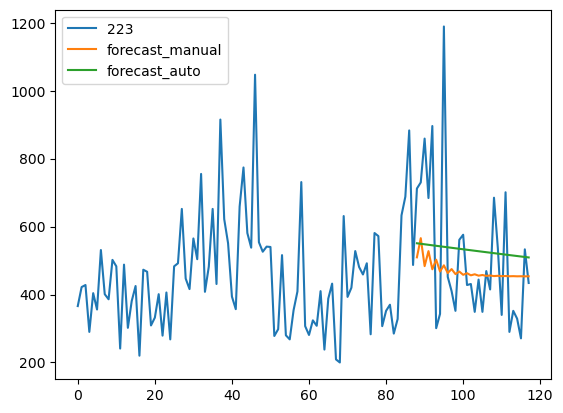

In [22]:
#Plotting Autofit, Manual Fit ARIMA on original dataset:

forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto']=[None]*len(df_train) + list(forecast_test_auto)
df.plot()

In [23]:
#Interpreting the Autofitted ARIMA forecast Visually

#No significant correlation with the training data in terms of predicting swings, predicts export value at the end of the timeframe to a lower degree of 
#accuracy than the manually fitted ARIMA model.

In [24]:
#Evaluating the manual ARIMA model predictions
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae=mean_absolute_error(df_test, forecast_test)
mape=mean_absolute_percentage_error(df_test, forecast_test)
rmse=np.sqrt(mean_squared_error(df_test, forecast_test))
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 147.86252032667042
mape - manual: 0.27776126682808217
rmse - manual: 204.49818700354723


In [25]:
#Evaluating the Autofitted ARIMA model predictions
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae=mean_absolute_error(df_test, forecast_test_auto)
mape=mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse=np.sqrt(mean_squared_error(df_test, forecast_test_auto))
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 165.32035863623997
mape - manual: 0.3510936001944629
rmse - manual: 204.22559934564163


In [26]:
#Evaluation

#Overall, the manually fitted and Autofitted ARIMA models have huge error, as compared to a hybrid ARIMA/LTSM model created by Bina Nusantara University
#I found in a paper intended to forecast Indonesian exports [ref7]. The MAPE of my better performing model (Manually fitted, (p,d,q)=(2,0,3)) is 27.78%,
#while the MAPE of their model is 7.38%.

#Absolutely dismal performance from my model to be honest by a difference of over 20% error compared to the chosen benchmark.
#I will discuss potential reasons below. 

In [27]:
#Limitations/Improvements

#1. Could have used a longer timeframe, with a seasonal ARIMA model (sARIMA). Might have yielded better results. 
#2. Very weak general trend may have played a part in us being unable to observe anything meaningful on the ARIMA plots **Visually**. 
#3. Did not perform walk-forward analysis (partially also because I don't really have the time to digest and understand 
#the coding involved right now). 
#4. Did not consider trying again with alternative, non-seasonally adjusted data in the interest of time upon getting a model with huge mean error. 
#5. ARIMA can be sensitive to outliers and extreme values, which is definitely the case with this particular dataset as the exports swing frequently
#and to a large extent. 

In [28]:
#Conclusion

#In my opinion, The ACF and PACF plots for the dataset were practically that of white noise - if I had not included the additional points as 'significant lag'
#other than lag order = 0, we might as well have not carried out the rest of the ARIMA model. But in the interest of actually doing something with the data I chose 
#to use a little imagination and allow those lags in. 

#However, while the forecast plot (understandably) failed to predict the swings in export value, it managed to predict the export value in 30 days 
#time to a reasonable degree of accuracy between the start and end of the training period. I believe this is indicative of the MA component of the ARIMA
#model performing well.

#As for the auto-fitted ARIMA model, I have the same conclusion as for manual ARIMA when it comes to the swings in export value. Additionally, It was even less 
#accurate in predicting the value of exports by the end of the time period selected.

#In conclusion, our manually fitted ARIMA model with parameters (2,0,3) performed slightly better than the autofitted ARIMA with parameters (1,0,1), but 
#performed poorly against a benchmark with a similar dataset and modelling approach. The next step is to attempt a walk-forward approach or a pure MA approach
#with parameters (0,0,q) since the MA component of the model seemed to perform decently for the 30-day training period. 

#(Or maybe give up on this particular model/dataset combination because the ACF and PACF plots suck)

In [29]:
#References
#1. https://builtin.com/data-science/time-series-forecasting-python
#2. https://www.youtube.com/watch?v=-aCF0_wfVwY
#3. https://www.researchgate.net/post/What-should-be-the-minimum-number-of-observations-for-a-time-series-model#:~:text=For%20autoregressive%20integrated%20moving%20average,(Box%20and%20Tiao%201975).
#4. https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/datasets/uktradeallcountriesseasonallyadjusted
#5. https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf
#6. https://spureconomics.com/interpreting-acf-and-pacf-plots/
#7. Forecasting Indonesia Exports using a Hybrid Model ARIMALSTM - Emmanuel Dave, Albert Leonardo, Marethia Jeanice, Novita Hanafiah